<a href="https://colab.research.google.com/github/wiendewani/Image-Retrieval/blob/main/Final%20Code%20/%20Final_Image_Retrieval_ResNet50_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

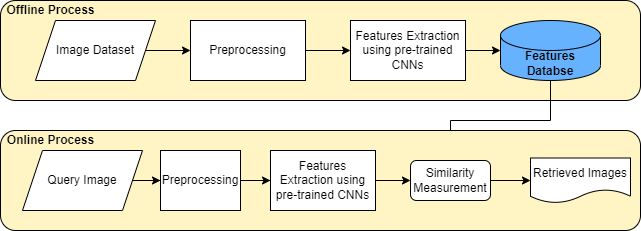

## import library

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
from skimage.transform import resize
import random
import skimage as sk
import skimage.io
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import manifold
import random
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import manifold
from multiprocessing import Pool
from skimage.transform import resize
import skimage.io
from multiprocessing import Pool
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
import copy
import sklearn.metrics as metric
from statistics import mean
import re


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install scikit-image 

## Data

In [ ]:
! git clone https://github.com/wiendewani/Image-Retrieval.git

Cloning into 'Image-Retrieval'...
remote: Enumerating objects: 1048, done.
remote: Counting objects: 100% (1048/1048), done.
remote: Compressing objects: 100% (1044/1044), done.
remote: Total 1048 (delta 55), reused 932 (delta 2), pack-reused 0
Receiving objects: 100% (1048/1048), 86.91 MiB | 35.84 MiB/s, done.
Resolving deltas: 100% (55/55), done.


## preprocessing

In [ ]:
class CV_IO_utils:
  def read_img(filePath):
      return skimage.io.imread(filePath, as_gray=False)

  def read_imgs_dir(dirPath, extensions, parallel=True):
      args = [os.path.join(dirPath, filename)
              for filename in os.listdir(dirPath)
              if any(filename.lower().endswith(ext) for ext in extensions)]
      if parallel:
          pool = Pool()
          imgs = pool.map(CV_IO_utils.read_img, args)
          pool.close()
          pool.join()
      else:
          imgs = [read_img(arg) for arg in args]
      return imgs

  # simpan gambar
  def save_img(filePath, img):
      skimage.io.imsave(filePath, img)

In [ ]:
class CV_transform_utils:
    
  def apply_transformer(imgs, transformer, parallel=True):
      if parallel:
          pool = Pool()
          imgs_transform = pool.map(transformer, [img for img in imgs])
          pool.close()
          pool.join()
      else:
          imgs_transform = [transformer(img) for img in imgs]
      return imgs_transform

  # Normalize 
  def normalize_img(img):
      return img / 255.

  # Resize image
  def resize_img(img, shape_resized):
      img_resized = resize(img, shape_resized,
                          anti_aliasing=True,
                          preserve_range=True)
      assert img_resized.shape == shape_resized
      return img_resized

  # Flatten image
  def flatten_img(img):
      return img.flatten("C")

In [ ]:

# class utils:
#     # Get split indices
#   def split(fracs, N, seed):
#       fracs = [round(frac, 2) for frac in fracs]
#       if sum(fracs) != 1.00:
#           raise Exception("fracs do not sum to one!")

#       # Shuffle ordered indices
#       indices = list(range(N))
#       random.Random(seed).shuffle(indices)
#       indices = np.array(indices, dtype=int)

#       # Get numbers per group
#       n_fracs = []
#       for i in range(len(fracs) - 1):
#           n_fracs.append(int(max(fracs[i] * N, 0)))
#       n_fracs.append(int(max(N - sum(n_fracs), 0)))

#       if sum(n_fracs) != N:
#           raise Exception("n_fracs do not sum to N!")

#       # Sample indices
#       n_selected = 0
#       indices_fracs = []
#       for n_frac in n_fracs:
#           indices_frac = indices[n_selected:n_selected + n_frac]
#           indices_fracs.append(indices_frac)
#           n_selected += n_frac

#       # Check no intersections
#       for a, indices_frac_A in enumerate(indices_fracs):
#           for b, indices_frac_B in enumerate(indices_fracs):
#               if a == b:
#                   continue
#               if utils.is_intersect(indices_frac_A, indices_frac_B):
#                   raise Exception("there are intersections!")

#       return indices_fracs

#   # Is there intersection?
#   def is_intersect(arr1, arr2):
#       n_intersect = len(np.intersect1d(arr1, arr2))
#       if n_intersect == 0: return False
#       else: return True

In [ ]:
imgs_test[0].shape

(256, 384, 3)

##Feature Extraction

In [ ]:
correct = 0
wrong = 0
loss_ = []
acc_ = []
ground_truth = []
retrieval_labels = []
prec_list = []
rec_list = []

acc_transfer = []
loss_transfer = []
prec_transfer = []
rec_transfer = []


retrieval_label=os.listdir(r"/content/Image-Retrieval/Dataset/training_set")
truth_label=os.listdir(r"/content/Image-Retrieval/Dataset/test_set")

# Apply transformations to all images
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = CV_transform_utils.resize_img(img, self.shape_resize)
        img_transformed = CV_transform_utils.normalize_img(img_transformed)
        return img_transformed



# Run mode:  (transfer learning -> Restnet50)
modelName = "Restnet50" 
trainModel = True
parallel = True 

# Make paths
dataTrainDir = os.path.join(os.getcwd(), "/content/Image-Retrieval/Dataset/training_set")
dataTestDir = os.path.join(os.getcwd(), "/content/Image-Retrieval/Dataset/test_set")
outDir = os.path.join(os.getcwd(), "output", modelName)
if not os.path.exists(outDir):
    os.makedirs(outDir)

# Read images
extensions = [".jpg", ".jpeg"]
print("Reading train images from '{}'...".format(dataTrainDir))
imgs_train = CV_IO_utils.read_imgs_dir(dataTrainDir, extensions, parallel=parallel)
print("Reading test images from '{}'...".format(dataTestDir))
imgs_test = CV_IO_utils.read_imgs_dir(dataTestDir, extensions, parallel=parallel)
shape_img = imgs_train[0].shape
print("Image shape = {}".format(shape_img))




Reading train images from '/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/training_set'...
Reading test images from '/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/test_set'...
Image shape = (256, 384, 3)


In [ ]:

print("Loading ResNet50 pre-trained model...")
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_shape=shape_img)
model.summary()

shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
n_epochs = None


# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))


transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_train_transformed = CV_transform_utils.apply_transformer(imgs_train, transformer, parallel=parallel)
print("Applying image transformer to test images...")
imgs_test_transformed = CV_transform_utils.apply_transformer(imgs_test, transformer, parallel=parallel)

# Convert images to numpy array
X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))
print(" -> X_test.shape = {}".format(X_test.shape))



# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
E_test = model.predict(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model)))
print(" -> E_train.shape = {}".format(E_train.shape))
print(" -> E_test.shape = {}".format(E_test.shape))
print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
print(" -> E_test_flatten.shape = {}".format(E_test_flatten.shape))


# Fit kNN model on training images
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=10, metric="cosine")
knn.fit(E_train_flatten)

# Perform image retrieval on test images
print("Performing image retrieval on test images...")
for i, emb_flatten in enumerate(E_test_flatten):
    _, indices = knn.kneighbors([emb_flatten]) # find k nearest train neighbours
    img_query = imgs_test[i] # query image
    imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()] # retrieval images
    for x in indices.flatten():
      if truth_label[i][:3] in retrieval_label[x]:
        correct = correct + 1
      else:
        wrong = wrong + 1
    loss_.append((wrong/5))
    acc_.append((correct/5))
    correct = 0
    wrong = 0

    # Precision Recall
    for x in indices.flatten():
      ground_truth.append(re.split("(\d.*)", truth_label[i])[0])
      retrieval_labels.append(re.split("(\d.*)", retrieval_label[x])[0])
    
    rec_list.append(metric.recall_score(ground_truth, retrieval_labels, average='weighted'))
    prec_list.append(metric.precision_score(ground_truth, retrieval_labels, average='weighted'))

    ground_truth.clear()
    retrieval_labels.clear()

    outFile = os.path.join(outDir, "{}_retrieval_{}.png".format(modelName, i))
    CV_plot_utils.plot_query_retrieval(img_query, imgs_retrieval, outFile)

print("retrieval accuracy: {}".format(mean(acc_)))
print("retrieval loss: {}".format(mean(loss_)))
print("retrieval precision: {}".format(mean(prec_list)))
print("retrieval recall: {}".format(mean(rec_list)))

Loading ResNet50 pre-trained model...
94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 390, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 192, 64  9472        ['conv1_pad[0][0]']              
                                )                                                      

In [ ]:

print("Loading ResNet50 pre-trained model...")
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_shape=shape_img)
model.summary()

shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
n_epochs = None


# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))


transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_train_transformed = CV_transform_utils.apply_transformer(imgs_train, transformer, parallel=parallel)
print("Applying image transformer to test images...")
imgs_test_transformed = CV_transform_utils.apply_transformer(imgs_test, transformer, parallel=parallel)

# Convert images to numpy array
X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))
print(" -> X_test.shape = {}".format(X_test.shape))

# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
E_test = model.predict(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model)))
print(" -> E_train.shape = {}".format(E_train.shape))
print(" -> E_test.shape = {}".format(E_test.shape))
print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
print(" -> E_test_flatten.shape = {}".format(E_test_flatten.shape))


# Fit kNN model on training images
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=9, metric="cosine")
knn.fit(E_train_flatten)

# Perform image retrieval on test images
print("Performing image retrieval on test images...")
for i, emb_flatten in enumerate(E_test_flatten):
    _, indices = knn.kneighbors([emb_flatten]) # find k nearest train neighbours
    img_query = imgs_test[i] # query image
    imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()] # retrieval images
    for x in indices.flatten():
      if truth_label[i][:3] in retrieval_label[x]:
        correct = correct + 1
      else:
        wrong = wrong + 1
    loss_.append((wrong/5))
    acc_.append((correct/5))
    correct = 0
    wrong = 0

    # Precision Recall
    for x in indices.flatten():
      ground_truth.append(re.split("(\d.*)", truth_label[i])[0])
      retrieval_labels.append(re.split("(\d.*)", retrieval_label[x])[0])
    
    rec_list.append(metric.recall_score(ground_truth, retrieval_labels, average='weighted'))
    prec_list.append(metric.precision_score(ground_truth, retrieval_labels, average='weighted'))

    ground_truth.clear()
    retrieval_labels.clear()

# print("retrieval accuracy: {}".format(mean(acc_)))
# print("retrieval loss: {}".format(mean(loss_)))
print("retrieval precision: {}".format(mean(prec_list)))
print("retrieval recall: {}".format(mean(rec_list)))

# Bis

In [ ]:


correct = 0
wrong = 0
loss_ = []
acc_ = []
ground_truth = []
retrieval_labels = []
prec_list = []
rec_list = []

acc_transfer = []
loss_transfer = []
prec_transfer = []
rec_transfer = []


retrieval_label=os.listdir(r"/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/training_set")
truth_label=os.listdir(r"/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/test_set")

# Apply transformations to all images
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = CV_transform_utils.resize_img(img, self.shape_resize)
        img_transformed = CV_transform_utils.normalize_img(img_transformed)
        return img_transformed



# Run mode:  (transfer learning -> Restnet50)
modelName = "Restnet50" 
trainModel = True
parallel = True 

# Make paths
dataTrainDir = os.path.join(os.getcwd(), "/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/training_set")
dataTestDir = os.path.join(os.getcwd(), "/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/test_set")
outDir = os.path.join(os.getcwd(), "output", modelName)
if not os.path.exists(outDir):
    os.makedirs(outDir)

# Read images
extensions = [".jpg", ".jpeg"]
print("Reading train images from '{}'...".format(dataTrainDir))
imgs_train = CV_IO_utils.read_imgs_dir(dataTrainDir, extensions, parallel=parallel)
print("Reading test images from '{}'...".format(dataTestDir))
imgs_test = CV_IO_utils.read_imgs_dir(dataTestDir, extensions, parallel=parallel)
shape_img = imgs_train[0].shape
print("Image shape = {}".format(shape_img))




Reading train images from '/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/training_set'...
Reading test images from '/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/test_set'...
Image shape = (256, 384, 3)


In [ ]:

print("Loading ResNet50 pre-trained model...")
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_shape=shape_img)
model.summary()

shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
n_epochs = None
    # Build models




# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))


transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_train_transformed = CV_transform_utils.apply_transformer(imgs_train, transformer, parallel=parallel)
print("Applying image transformer to test images...")
imgs_test_transformed = CV_transform_utils.apply_transformer(imgs_test, transformer, parallel=parallel)

# Convert images to numpy array
X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))
print(" -> X_test.shape = {}".format(X_test.shape))




# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
E_test = model.predict(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model)))
print(" -> E_train.shape = {}".format(E_train.shape))
print(" -> E_test.shape = {}".format(E_test.shape))
print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
print(" -> E_test_flatten.shape = {}".format(E_test_flatten.shape))




Loading ResNet50 pre-trained model...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 390, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 192, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                     

In [ ]:
# Fit kNN model on training images
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=9, metric="cosine")
knn.fit(E_train_flatten)

# Perform image retrieval on test images
print("Performing image retrieval on test images...")
for i, emb_flatten in enumerate(E_test_flatten):
    _, indices = knn.kneighbors([emb_flatten]) # find k nearest train neighbours
    img_query = imgs_test[i] # query image
    imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()] # retrieval images
    for x in indices.flatten():
      if truth_label[i][:3] in retrieval_label[x]:
        correct = correct + 1
      else:
        wrong = wrong + 1
    loss_.append((wrong/5))
    acc_.append((correct/5))
    correct = 0
    wrong = 0

    # Precision Recall
    for x in indices.flatten():
      ground_truth.append(re.split("(\d.*)", truth_label[i])[0])
      retrieval_labels.append(re.split("(\d.*)", retrieval_label[x])[0])
    
    rec_list.append(metric.recall_score(ground_truth, retrieval_labels, average='weighted'))
    prec_list.append(metric.precision_score(ground_truth, retrieval_labels, average='weighted'))

    ground_truth.clear()
    retrieval_labels.clear()

    # outFile = os.path.join(outDir, "{}_retrieval_{}.png".format(modelName, i))
    # CV_plot_utils.plot_query_retrieval(img_query, imgs_retrieval, outFile)

# print("retrieval accuracy: {}".format(mean(acc_)))
# print("retrieval loss: {}".format(mean(loss_)))
print("retrieval precision: {}".format(mean(prec_list)))
print("retrieval recall: {}".format(mean(rec_list)))

Fitting k-nearest-neighbour model on training images...
Performing image retrieval on test images...
retrieval precision: 1.0
retrieval recall: 1.0


In [ ]:
truth_label

['102.jpg',
 '907.jpg',
 '300.jpg',
 '705.jpg',
 '5.jpg',
 '604.jpg',
 '200.jpg',
 '505.jpg',
 '800.jpg',
 '401.jpg']

In [ ]:
retrieval_labels

[]

In [ ]:
model.save('/content/drive/MyDrive/Kembali Citra Notebook/IR.h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/Kembali Citra Notebook/model_weights.h5')

In [ ]:
dataTrainDir = os.path.join(os.getcwd(), "/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/training_set")
dataTestDir = os.path.join(os.getcwd(), "/content/drive/MyDrive/Kembali Citra Notebook/corel_dataset/test_set")

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(dataTrainDir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (256, 384))
            train_data.append(np.array(image))
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [ ]:
train_data.shape

(900, 384, 256, 3)

In [ ]:
np.save('data.npy', train_data)

In [ ]:
import numpy as np
print(np.asarray(train_data).shape)
# train_data.shape

(900, 384, 256, 3)
